In [40]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    import os
    os.chdir("/content/gdrive/My Drive/Colab Notebooks/ml_music/music")
except ImportError:
    print("Not in colab.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
import pretty_midi as pm
import scipy
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
import tensorflow as tf
tf.enable_eager_execution()


if not os.getcwd().endswith("/music"):
    os.chdir("music")

# infにmidiを読み込む
inf = pm.PrettyMIDI('example.mid')
inf.instruments

#中身の確認
x = inf.instruments[0]
print(len(x.notes))
print(x.is_drum)
print(x.name)
print(x.get_pitch_class_histogram())

x.program

170
False

[30.  0. 10.  2. 22. 32.  6. 20.  0. 28. 20.  0.]


0

Tempo: 155.833489
(128, 72)


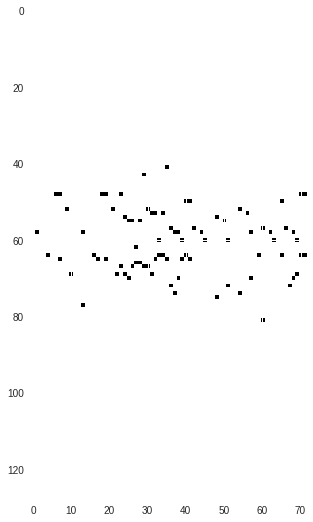

In [42]:
# ドラムを使わない。音符の多い8つのトラック(intrument)に限定
def IsolateMelody(dat):
  interesting = [i for i in dat.instruments if lambda i: len(i.notes)>0 and not i.is_drum]
  interesting = sorted(interesting, reverse=True, key=lambda i: len(i.notes))
  return interesting[0:8]

# 8つのトラックを1つ目に全部入れる。
def MergeInstruments(insts):
  out = insts[0]
  out.name = "merged"
  for inst in insts[1:]:
    out.notes += inst.notes
  return out

inf = pm.PrettyMIDI('example.mid')
out = pm.PrettyMIDI()
out.instruments = [MergeInstruments(IsolateMelody(inf))]
out.write("testout.mid")
print("Tempo: %f" % out.estimate_tempo())
pr = out.get_piano_roll(fs=out.estimate_tempo()/60/2)
#pr = out.get_chroma(times=out.get_beats())
print(pr.shape)

fig = plt.figure(figsize=(14, 9))
ax  = fig.add_subplot(1, 1, 1)
plt.imshow(pr)

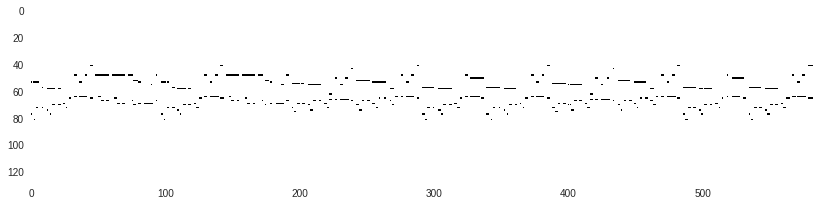

In [43]:
def Datify(file):
  md = pm.PrettyMIDI(file);
  out = pm.PrettyMIDI()
  out.instruments = [MergeInstruments(IsolateMelody(md))]
  dat = {'src': file, 'midi': md, 'simplified': out}
  dat['tempo'] = out.estimate_tempo()
  dat['fs'] = out.estimate_tempo()/60*4
  dat['frames'] = out.get_end_time() / dat['fs']
  dat['pr'] = out.get_piano_roll(dat['fs'])
  return dat

def Sequify(file):
  return Datify(file)['pr'];

def ExpSeq(pr):
  # We need to broadcast the image array such that it has a batch dimension
  # https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  return np.expand_dims(pr, axis=0)

def SqSeq(pr):
  return np.squeeze(pr, axis=0)

def Pr(dat):
  return dat['pr']

def PlotPR(pr):
  fig = plt.figure(figsize=(14, 9))
  ax  = fig.add_subplot(1, 1, 1)
  #img = SqSeq(pr)
  img = pr
  plt.imshow(img)

PlotPR(Sequify("example.mid"))

In [0]:
if True:
  corpus = [Datify(file) for file in sorted(glob.glob("liszt/*.mid"))]

In [45]:
print(len(corpus))
print(corpus[0]['pr'].shape)

11
(128, 13400)


In [0]:
# 学習して生成したpiano rollをmidi fileを元に戻す
import pretty_midi
def piano_roll_to_pretty_midi(piano_roll, fs=100.0, program=1):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.abs(np.diff(piano_roll).T)>10) # 要素間の差分をとる

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes, dtype=int)

    fs = float(fs)
    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        if velocity > 20:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = np.clip(velocity, 0, 127)
        elif prev_velocities[note] > 0:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note] / fs,
                end=time / fs)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm

In [47]:
# 前処理と後処理の確認。corp0-in.midがinput、corp0-simp.midが前処理後、corp0-conv.midが
# corp0-simp.midを一度piano rollに変換した後midiファイルに戻したもの。
np.savetxt("corp0.tsv", corpus[0]['pr'], delimiter="\t")
piano_roll_to_pretty_midi(corpus[0]['pr'], corpus[0]['fs']).write("corp0-conv.mid")
print("Wrote: %s @ %s" % (corpus[0]['src'], corpus[0]['fs']))
corpus[0]['midi'].write("corp0-in.mid")
corpus[0]['simplified'].write("corp0-simp.mid")
print(corpus[0])

Wrote: liszt/liz_donjuan.mid @ 13.260349837994438
{'pr': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'src': 'liszt/liz_donjuan.mid', 'fs': 13.260349837994438, 'midi': <pretty_midi.pretty_midi.PrettyMIDI object at 0x7ff57c85e510>, 'tempo': 198.90524756991658, 'simplified': <pretty_midi.pretty_midi.PrettyMIDI object at 0x7ff581f726d0>, 'frames': 76.21065079688408}


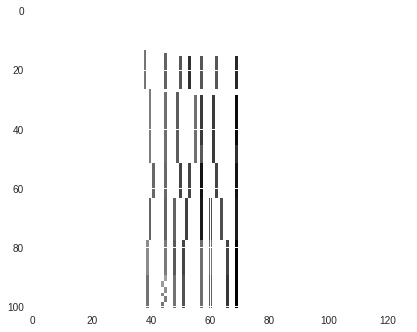

In [48]:
# data should be made by Datify(file)
SEQ_LENGTH = 100
def data_to_seq_dataset(data):
  """  Convert data to dataset of sequence
   
    Parameters
    ----------
    data : dict
        Data made by Datify
   
   Returns
    -------
    tf.data.Dataset
        Dataset of seqences. Length of each sequence is SEQ_LENGTH.
   """
  #ref https://www.tensorflow.org/tutorials/sequences/text_generation
  piano_roll = tf.cast(data["pr"].T, tf.float32)
  piano_roll_dataset = tf.data.Dataset.from_tensor_slices(piano_roll)
  return piano_roll_dataset.batch(SEQ_LENGTH+1, drop_remainder=True)

# Test data_to_seq_dataset with an example
example_seq_dataset = data_to_seq_dataset(corpus[0])
for item in example_seq_dataset.take(1):
  plt.imshow(item)

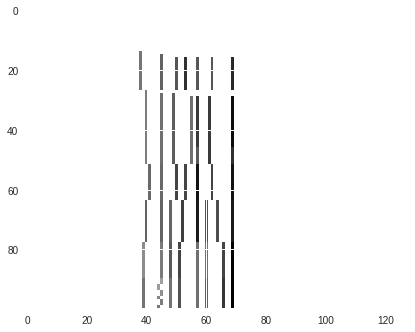

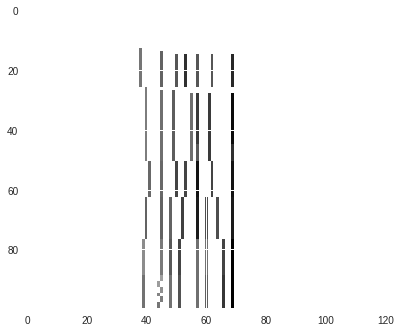

In [49]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

example_seq_dataset_split = example_seq_dataset.map(split_input_target)

for item in example_seq_dataset_split .take(1):
  plt.figure()
  plt.imshow(item[0])
  plt.figure()
  plt.imshow(item[1])

In [50]:
BATCH_SIZE = 64
# steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

datasets = (data_to_seq_dataset(data) for data in corpus)
dataset = reduce(lambda x, y: x.concatenate(y), datasets) 
dataset = dataset.map(split_input_target)
#ref https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset_size = sum(1 for x in dataset)


# Split dataset into test and training
validation_dataset_size = 1
validation_dataset = dataset.take(validation_dataset_size)
training_dataset = dataset.skip(validation_dataset_size)
training_dataset_size = sum(1 for x in training_dataset)

("dataset_size", dataset_size, "validation_dataset_size", validation_dataset_size, "training_dataset_size", training_dataset_size)

('dataset_size', 9, 'validation_dataset_size', 1, 'training_dataset_size', 8)

In [140]:
# The embedding dimension
embedding_dim = 512
# The number of notes in one column of piano roll.
keys_dim = 128
rnn_units = 1024
window_size = 4
use_gpu = tf.test.is_gpu_available()

model_path = "model_window%d_dense%d_lstm%d_%s.h5" % (
    window_size,
    embedding_dim,
    rnn_units,
    "gpu" if use_gpu else "cpu")
print(model_path)

if use_gpu:
  rnn = tf.keras.layers.CuDNNLSTM
else:
  rnn =tf.keras.layers.LSTM

def build_model(batch_size, seq_length):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            embedding_dim,
            batch_input_shape=[
                batch_size, seq_length / window_size, keys_dim * window_size]),
        rnn(
            rnn_units,
             return_sequences=True, 
             recurrent_initializer='glorot_uniform',
             stateful=True),
        tf.keras.layers.Dense(keys_dim*window_size),
    ])

model = build_model(BATCH_SIZE, SEQ_LENGTH)

#保存済みモデルがあったら読み込む。
if os.path.exists(model_path):
    model.load_weights(model_path)

model.compile(loss="mean_squared_error", optimizer=tf.train.AdamOptimizer())
model.summary()

model_window4_dense512_lstm1024_gpu.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (64, 25, 512)             262656    
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (64, 25, 1024)            6299648   
_________________________________________________________________
dense_21 (Dense)             (64, 25, 512)             524800    
Total params: 7,087,104
Trainable params: 7,087,104
Non-trainable params: 0
_________________________________________________________________


### Try the model

In [162]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(tf.reshape(input_example_batch,  model.input_shape))
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(64), Dimension(25), Dimension(512)]), '# (batch_size, sequence_length, vocab_size)')


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

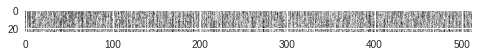

In [142]:
plt.imshow(example_batch_predictions.numpy()[0])

In [0]:
piano_roll_to_pretty_midi(example_batch_predictions.numpy()[0]).write("try-the-model.mid")

### Train the model

In [163]:
print(training_dataset)
reshape = lambda x, y: (tf.reshape(x, model.input_shape), tf.reshape(y, model.output_shape))
reshaped_training_dataset = training_dataset.map(reshape)
reshaped_validation_dataset = validation_dataset.map(reshape)
# validation_split is not supported when treating dataset.
model.fit(reshaped_training_dataset.repeat(),
          epochs=100,
          steps_per_epoch=training_dataset_size,
          validation_data=reshaped_validation_dataset.repeat(),
          validation_steps=validation_dataset_size)
model.save(model_path)

<SkipDataset shapes: ((64, 100, 128), (64, 100, 128)), types: (tf.float32, tf.float32)>
Epoch 1/100
8/8 [==============================] - 1s 103ms/step - loss: 9.7679 - val_loss: 8.7951
Epoch 2/100
8/8 [==============================] - 1s 99ms/step - loss: 9.6242 - val_loss: 10.4736
Epoch 3/100
8/8 [==============================] - 1s 102ms/step - loss: 9.3777 - val_loss: 9.8657
Epoch 4/100
8/8 [==============================] - 1s 103ms/step - loss: 9.4696 - val_loss: 8.5786
Epoch 5/100
8/8 [==============================] - 1s 101ms/step - loss: 9.2405 - val_loss: 10.6184
Epoch 6/100
8/8 [==============================] - 1s 102ms/step - loss: 9.3863 - val_loss: 8.9656
Epoch 7/100
8/8 [==============================] - 1s 105ms/step - loss: 9.2496 - val_loss: 8.6457
Epoch 8/100
8/8 [==============================] - 1s 103ms/step - loss: 9.0858 - val_loss: 10.9782
Epoch 9/100
8/8 [==============================] - 1s 101ms/step - loss: 8.8084 - val_loss: 7.6992
Epoch 10/100
8/8 [=

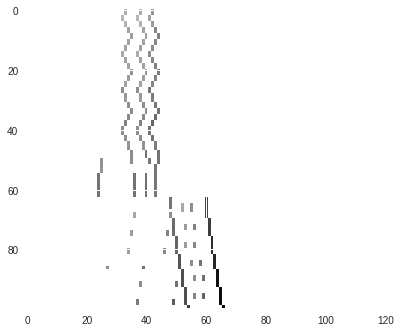

In [165]:
for input_example_batch, target_example_batch in dataset.take(1): 
    plt.imshow(target_example_batch.numpy()[0])
    piano_roll_to_pretty_midi(target_example_batch.numpy()[0].T).write("train-the-model-target.mid")
    example_batch_predictions_2 = model(tf.reshape(input_example_batch, model.input_shape))

In [0]:
# piano_roll_to_pretty_midi(example_batch_predictions_2.numpy()[0].T).write("train-the-model.mid")
# plt.imshow(example_batch_predictions_2.numpy()[0])

In [147]:
print(np.where((np.diff(example_batch_predictions_2.numpy()[0].T).T)>10))

(array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
        9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 12, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]), array([194, 197, 324, 327, 452, 455,  70,  73, 200, 203, 329, 332, 334,
       457, 459, 460, 462,  76,  79, 206, 209, 335, 338, 340, 463, 465,
       466, 468,  82,  85, 212, 215, 341

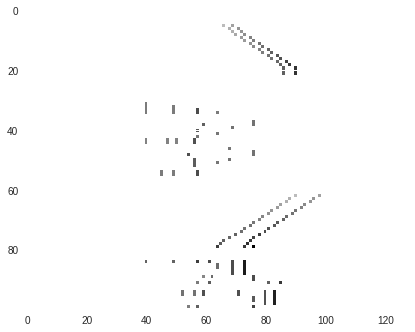

In [148]:
plt.imshow(piano_roll_to_pretty_midi(target_example_batch.numpy()[0].T).get_piano_roll().T)

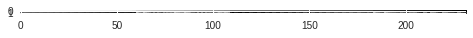

In [149]:
plt.imshow(np.nonzero(np.diff(target_example_batch.numpy()[0], axis = 0)))

### Generate Music

In [167]:
gen_model = build_model(1, window_size)
gen_model.load_weights(model_path)
gen_model.build(tf.TensorShape([1, 1, keys_dim * window_size]))
gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (1, 1, 512)               262656    
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (1, 1, 1024)              6299648   
_________________________________________________________________
dense_25 (Dense)             (1, 1, 512)               524800    
Total params: 7,087,104
Trainable params: 7,087,104
Non-trainable params: 0
_________________________________________________________________


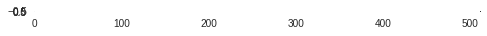

In [171]:
# Try to generate first
gen_model.reset_states()
example_predictions = gen_model(np.zeros([1, 1, keys_dim * window_size], dtype=np.float32))
plt.imshow(example_predictions[0])

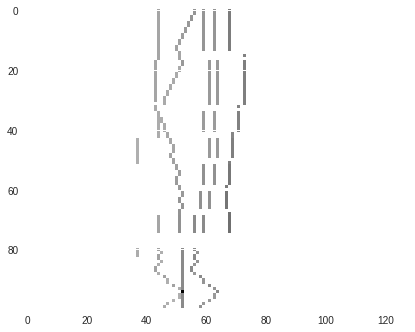

In [172]:
# Use randomly training data
def intro_from_dataset():
  return list(dataset.shuffle(BUFFER_SIZE).take(1))[0][0][0]

plt.imshow(intro_from_dataset())

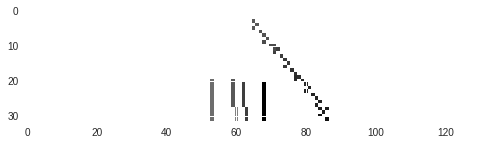

In [173]:
def data_to_intro(data, length):
  return data['pr'].T[:length]

plt.imshow(data_to_intro(corpus[4], 32))

liszt/liz_et_trans4.mid


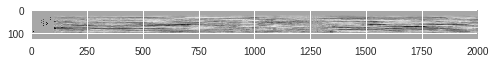

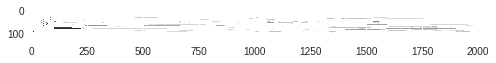

In [222]:
def generate_music(intro, total_length, midi_path, fs):
  intro = intro.reshape([-1, 512])
  window_count = total_length / window_size
  result = np.zeros([window_count, keys_dim * window_size], dtype=np.float32)
  result[0:intro.shape[0]] = intro
  # Generate piano roll.
  gen_model.reset_states()
  for i in range(window_count - 1):
    input = tf.expand_dims(result[i : i +1], 0)
    predictions = gen_model(input)
    if i > intro.shape[0] - 2:
      result[i +1] = predictions[0]
  # Visualize to midi file
  result_midi = piano_roll_to_pretty_midi(result.reshape([-1, 128]).T, fs)
  result_midi.write(midi_path)
  # Visualize
  plt.figure()
  plt.imshow(result.reshape([-1, 128]).T)
  plt.figure()
  plt.imshow(result_midi.get_piano_roll(fs))

# Test generating music using introduction of 4th corpus.
print(corpus[3]['src'])
generate_music(data_to_intro(corpus[3], 100), 2000, "result.midi", corpus[3]["fs"])

liszt/liz_donjuan.mid
liszt/liz_et1.mid
liszt/liz_et2.mid
liszt/liz_et_trans4.mid
liszt/liz_et_trans5.mid
liszt/liz_et_trans8.mid
liszt/liz_rhap02.mid
liszt/liz_rhap09.mid
liszt/liz_rhap10.mid
liszt/liz_rhap12.mid
liszt/liz_rhap15.mid


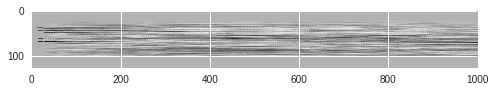

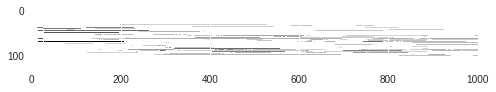

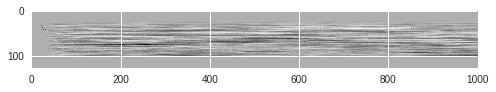

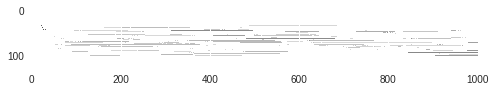

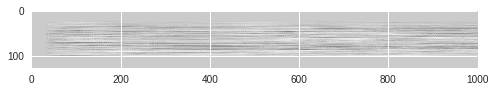

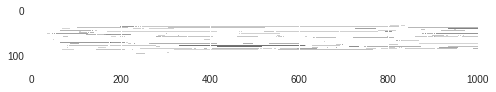

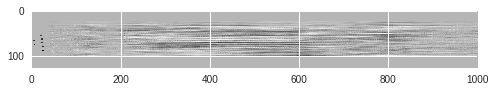

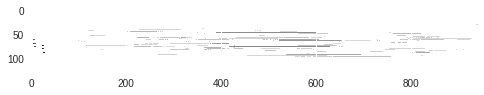

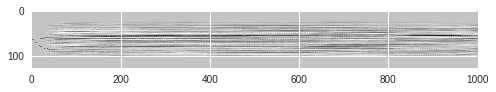

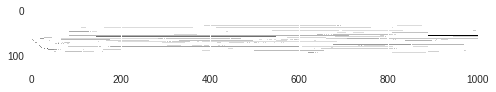

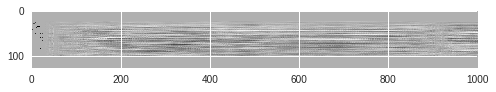

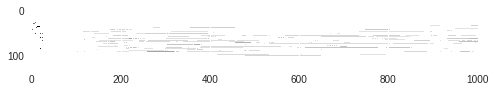

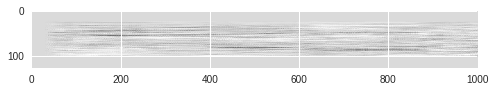

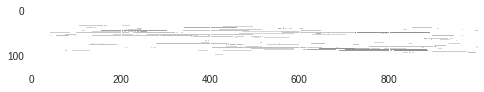

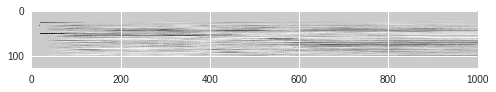

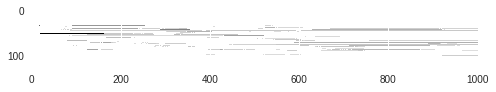

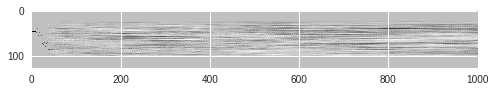

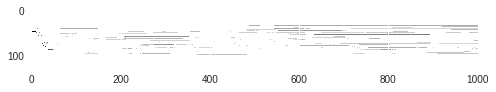

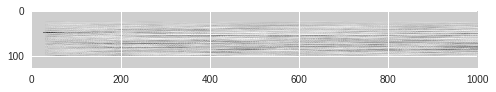

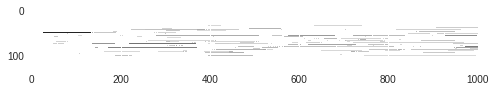

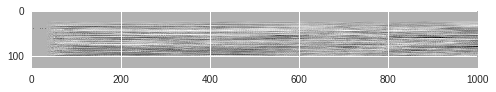

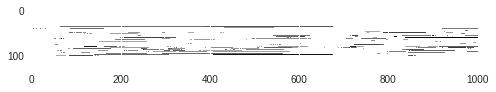

In [223]:
# Generate all from corpus
for data in corpus:
  path = data['src'].replace("liszt/", "liszt_result/")
  print(data['src'])
  generate_music(data_to_intro(data, 32), 1000, path, data["fs"])